# Churn prediction for Sparkify Music Service
## <center> 2. Data Exploration</center>
![EDA](./images/eda.png)


In [1]:
import datetime
from time import time
import pprint

from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, udf
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, DoubleType, LongType, IntegerType, DateType, TimestampType
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
import utils

In [3]:
%store -r events_data_path
pp = pprint.PrettyPrinter(indent=4)
events_data_path

'data/mini_sparkify_event_data.json'

In [4]:
# Make the output more like pandas and less like command-line SQL
spark.sparkContext.getConf().getAll();

In [5]:
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

In [6]:
spark

### Cleaning the data <a id='clean'></a>

In [7]:
events_df = utils.load_and_clean_data(spark, events_data_path)
events_df.count()

278154

In [8]:
pd.DataFrame(events_df.take(3), columns=events_df.columns).head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,song,status,ts,userAgent,userId,event_time,month,weekofyear,year,date
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,...,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 02:01:57,10,40,2018,2018-10-01
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 02:03:00,10,40,2018,2018-10-01
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,...,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 02:06:34,10,40,2018,2018-10-01


In [9]:
%%javascript
require("notebook/js/notebook").Notebook.prototype.scroll_to_bottom = function () {};

<IPython.core.display.Javascript object>

# Dataset Timespan

In [10]:
min_ts = events_df.agg({'ts': 'min'}).collect()[0][0]
max_ts = events_df.agg({'ts': 'max'}).collect()[0][0]
print('Dataset timespan: {:.0f} days.'.format((max_ts - min_ts) / (1000*60*60*24)))

Dataset timespan: 63 days.


In [11]:
min_date, max_date = events_df.select(F.min("date"), F.max("date")).first()
min_date, max_date

(datetime.date(2018, 10, 1), datetime.date(2018, 12, 3))

### Removing not needed columns for data exploration and feature engineering

In [12]:
not_needed_columns = ['firstName', 'lastName', 'method', 'userAgent', 'location']
events_df = events_df.drop(*not_needed_columns)

### Fields values types

In [13]:
numeric_cols = [f.name for f in events_df.schema.fields if 
            isinstance(f.dataType, DoubleType) or isinstance(f.dataType, LongType)
                or isinstance(f.dataType, IntegerType)]
numeric_cols

['itemInSession',
 'length',
 'registration',
 'sessionId',
 'status',
 'ts',
 'month',
 'weekofyear',
 'year']

In [14]:
string_cols = [f.name for f in events_df.schema.fields if 
            isinstance(f.dataType, StringType)]
string_cols

['artist', 'auth', 'gender', 'level', 'page', 'song', 'userId']

# <font color="blue"> Churn indicator <a id='churn'></a> </font>

### Authentication

In [15]:
events_df.createOrReplaceTempView("sparkify_view")
auth_data = spark.sql("""
    SELECT auth, COUNT(DISTINCT userId) as unique_users_count\
    FROM sparkify_view\
    WHERE userId IS NOT NULL AND userID != '' \
    GROUP BY auth \
    ORDER BY unique_users_count DESC
""")
pd.DataFrame(auth_data.collect(), columns=auth_data.columns).head()

,auth,unique_users_count
0,Logged In,225
1,Cancelled,52


`auth` field could represent a churn event.

### Visited Pages overview

In [16]:
pd.DataFrame(
    events_df.select('page','UserId').groupby('page').agg({'page':'count'})\
    .select('page','count(page)').collect(), columns=['page','count(page)'])

,page,count(page)
0,Cancel,52
1,Submit Downgrade,63
2,Thumbs Down,2546
3,Home,10082
4,Downgrade,2055
5,Roll Advert,3933
6,Logout,3226
7,Save Settings,310
8,Cancellation Confirmation,52
9,About,495


### Let's check if the users going to the page `Cancellation Confirmation`
Those are the same as the ones performing the `Cancelled` authentication event. That because the users count for both field is the same

In [17]:
churning_users = spark.sql("""
    SELECT COUNT(DISTINCT userId) as unique_users_count\
    FROM sparkify_view\
    WHERE userId IS NOT NULL AND userID != '' \
     AND auth='Cancelled' AND page='Cancellation Confirmation' 
""")

churning_users.show()

+------------------+
|unique_users_count|
+------------------+
|                52|
+------------------+



<div class="alert alert-block alert-info">
We could define churned users as those users who have visited the `Cancelation Confirmation` page. The action happens for both the Free-tier `level=free` and the Premium Subscription model `level=paid`. We could also consider users performing a `Submit Downgrade` action as churned users.
</div>


### Add new column `churn`
Set to `Churner` if the user visits `Cancellation Confirmation` or `Submit Downgrade` pages

In [18]:
events_df = utils.add_churn_column(events_df)

In [23]:
registered_users_ids = events_df.filter(col('auth') == 'Logged In').select('userId')
nb_registered_users = registered_users_ids.distinct().count()
nb_left_users = events_df[events_df.churn == 'Churner'].select("userId").distinct().count()
print("Number of registered users: {}".format(nb_registered_users))
print("Number of churned users: {}".format(nb_left_users))
print("Churn Rate: {:.2f}".format(nb_left_users / nb_registered_users))

Number of registered users: 225
Number of churned users: 92
Churn Rate: 0.41


In [24]:
print("Columns", events_df.columns)
numeric_cols.append("churn")
print("Numeric columns are ", numeric_cols)

Columns ['artist', 'auth', 'gender', 'itemInSession', 'length', 'level', 'page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userId', 'event_time', 'month', 'weekofyear', 'year', 'date', 'churn']
Numeric columns are  ['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts', 'month', 'weekofyear', 'year', 'churn']


In [25]:
events_df.columns

['artist',
 'auth',
 'gender',
 'itemInSession',
 'length',
 'level',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userId',
 'event_time',
 'month',
 'weekofyear',
 'year',
 'date',
 'churn']

In [26]:
utils.print_columns_unique_vals(events_df, ['auth', 'gender', 'level', 'status'])

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+

+------+
|gender|
+------+
|     F|
|     M|
+------+

+-----+
|level|
+-----+
| free|
| paid|
+-----+

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



# Data Exploration <a id='explore'></a>

## Customer Churn by account type (Free/Premium)

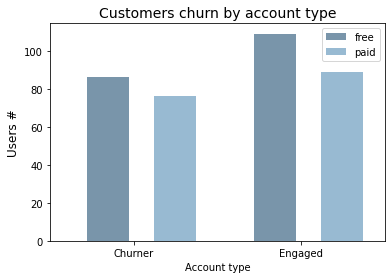

In [27]:
utils.plot_churners_groups_count(events_df, xlabel="Account type",
                           ylabel="Users #",
                           title="Customers churn by account type",
                           column="level", groups_column="churn", palette="Blues_d");

Users with Free account are slight more likely to churn than users with paid account

## Customer Churn by Gender

In [28]:
events_df = events_df \
    .replace(['M', 'F'], ['Male', 'Female'], 'gender')
gender_churn_data = events_df.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).\
        count().sort("churn").toPandas()

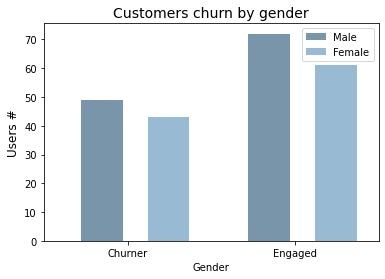

In [29]:
utils.plot_churners_groups_count(events_df, xlabel="Gender", ylabel="Users #",
                           title="Customers churn by gender",
                           column="Gender", groups_column="churn", palette="Blues_d");

Male customers are slight more likely to churn than female customers

## User account age in term of days

In [30]:
account_age_df = events_df \
    .select('userId', 'registration', 'ts', 'churn') \
    .withColumn('last_event', (events_df.ts - events_df.registration)) \
    .groupBy('userId', 'churn') \
    .agg({'last_event': 'max'}) \
    .withColumnRenamed('max(last_event)', 'account_age(days)') \
    .select('userId', 'churn',
            (col('account_age(days)') / (1000 * 60 * 60 * 24)).\
                cast(IntegerType()).alias('account_age(days)')
    ).toPandas()
account_age_df.head()

,userId,churn,account_age(days)
0,73,Churner,49
1,100004,Churner,172
2,36,Engaged,108
3,94,Engaged,132
4,114,Engaged,71


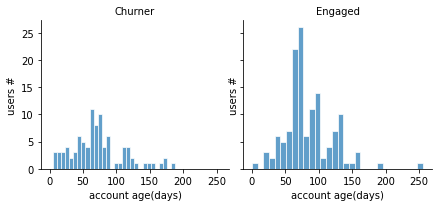

In [31]:
grp = sns.FacetGrid(account_age_df, col="churn", sharey=True)
grp.fig.subplots_adjust(wspace=.05, hspace=.05)
grp = grp.map(plt.hist, "account_age(days)", alpha=.7, edgecolor='w', bins=30)
for ax in grp.axes.flat:
    ax.set_title(ax.get_title().replace("churn = ", ""), fontsize=10)
    ax.set_ylabel("users #", fontsize=10)
    ax.set_xlabel("account age(days)", fontsize=10)

Users registered for a longer period are more likely to not churn

In [32]:
account_age_df[["account_age(days)"]].describe(percentiles=[0.25, 0.50, 0.75, 0.90])

,account_age(days)
count,225.000000
mean,79.364444
std,37.646625
min,0.000000
25%,59.000000
50%,73.000000
75%,100.000000
90%,129.800000
max,256.000000


## Percentage of users function of the usage period 
`account age`

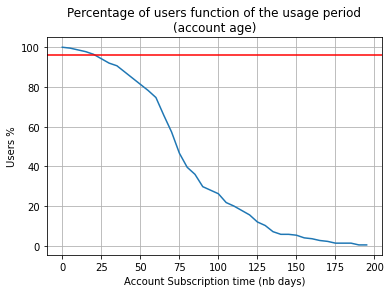

In [33]:
def age_filter(ages_df,  min_age):
    """Filter all events with age higher than min_age
    Args:
        ages_df: dataframe
        min_age: minimum ag
    """
    return np.sum(ages_df >= min_age)
range_ = range(0, 200, 5)
plt.plot(range_, [100 * age_filter(account_age_df["account_age(days)"], ma) / 
                  age_filter(account_age_df["account_age(days)"], 0) for ma in range_])
plt.axhline(96, color='red')
plt.ylabel("Users %")
plt.xlabel("Account Subscription time (nb days)")
plt.xticks = range(0, 200, 5)
plt.title("Percentage of users function of the usage period\n(account age)")
plt.grid()

In [34]:
account_age_df["userId"][account_age_df["account_age(days)"] >= 20]\
    .count() / account_age_df.count()

userId               0.964444
churn                0.964444
account_age(days)    0.964444
dtype: float64

<div class="alert alert-block alert-warning">
Keeping ~96% of the users (age greater than 20 days) should be sufficient to have a feature reflecting the service usage distribution over the time before churn event (here the last 20 days).
</div>

## Visited Pages by users type Churner/Engaged

In [35]:
pages_count = events_df.groupby(["page"]).count().toPandas().sort_values(by="count", ascending=False)
pages_count["rate"] = (pages_count["count"] / pages_count["count"].sum()).round(4)
pages_count[pages_count["page"] == "NextSong"]

,page,count,rate
13,NextSong,228108,0.8201


Filtering out NextSong pages for a more clear visulalization of pages visits count. That because it has a very high number relatively to the other pages

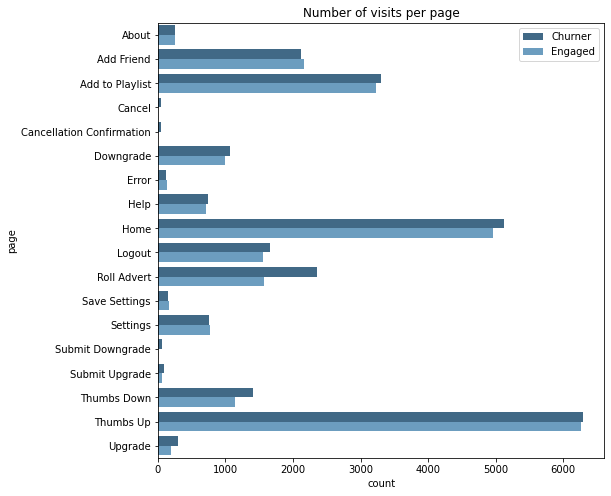

In [36]:
page_data = events_df.select(["page","churn"]).filter(col('page') != 'NextSong').\
    groupby([ "page","churn"]).count().sort("page").toPandas()
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot( x="count", y="page", hue="churn", data=page_data, ax=ax, palette="Blues_d");
plt.title("Number of visits per page")
plt.legend(title="");

It appears that most of the page visit counts can have an effect on the user engagement e.g `Thumbs Down`, `Roll Advert`, `NextSong`

Churning users have higher number of visits to the page `Roll Advert`

##  Measure customer engagement
<div class="alert alert-block alert-info">
 In general, if a customer regularly uses the service, there is nothing to worry about. If, on the other hand, the customer’s usage level drops off, there is a need to find out why it dropped and what to do about it.
 
So let's see how we can measure the service usage and engagement of the users.
</div >

### Average Number of played songs per day for each user

In [62]:
res = utils.get_nb_songs_per_col(
    events_df.withColumn("date", utils.ts_date_day(col("ts"))),
    "level", "date")
res

,level,avgSongsPerDate
0,free,32.318292
1,paid,87.089962


## Service usage over the last 20 days

### Average number of songs by day over the last 20 days

In [57]:
# 1. Get min and max dates for the last 20 days use of the service
usage_days_df1 = utils.get_data_last_ndays(events_df, page_filter="NextSong")
# 2. Get the usage average
last20days_usage_df1 = usage_days_df1 \
    .join(events_df, events_df.userId == usage_days_df1.userId) \
    .where(events_df["date"].between(col('20_days_before'), col('last_day'))) \
    .withColumn("date_index", utils.account_age_in_days(col("last_day"), col("date"))) \
    .groupby([events_df.userId, events_df.churn,
              events_df.date, col("date_index")
             ]).count() \
    .withColumnRenamed("count", "numSongsPerDay") \
    .groupby([events_df.churn, "date_index"]).mean("numSongsPerDay") \
    .withColumnRenamed("avg(numSongsPerDay)", "avgSongsPerDay") \
    .orderBy(events_df.churn, col("date_index").cast("int").asc())
# TODO use one single query to get the data instead of joining the dataframes

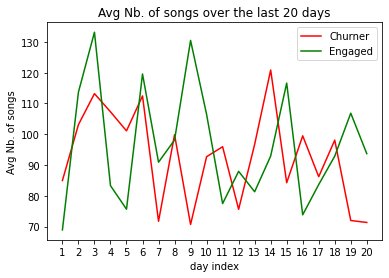

In [58]:
usage_data = last20days_usage_df1.toPandas()
usage_data['date_index'] = usage_data.date_index.apply(lambda x: int(x))
plt.xticks = range(0, 20, 4)
colors_dict={"Churner": "r", "Engaged": "g"}

utils.plot_days_usage(last20days_usage_df1.toPandas(),
                groups_column="churn", x_column="date_index",
                y_column="avgSongsPerDay",
                xlabel="Avg Nb. of songs", ylabel="day index",
                title="Avg Nb. of songs over the last 20 days",
                colors_dict=colors_dict)

The number of songs for `churning` users is slightly decreasing in the last 5 days before the churning event.

### Average number of sessions by day over the last 20 days

In [59]:
# 1. Get min and max dates for the last 20 days use of the service
usage_days_df1 = utils.get_data_last_ndays(events_df, page_filter="NextSong")
# 2. Get the sessions average
last20days_usage_df1 = usage_days_df1 \
    .join(events_df, events_df.userId == usage_days_df1.userId) \
    .where(events_df["date"].between(col('20_days_before'), col('last_day'))) \
    .withColumn("date_index",
                utils.account_age_in_days(col("last_day"), col("date")))\
    .groupby([events_df.userId, events_df.churn,
              events_df.date, "date_index", "sessionId"
    ]).count().groupby("date_index", "churn")\
    .mean("count") \
    .withColumnRenamed("avg(count)", "avg_sessions") \
    .orderBy(events_df.churn, col("date_index").cast("int").asc())

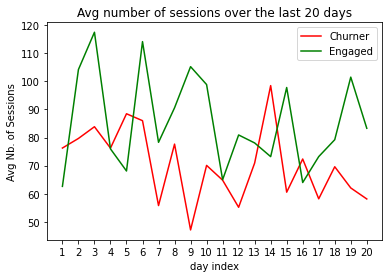

In [60]:
usage_data = last20days_usage_df1.toPandas()
usage_data['date_index'] = usage_data.date_index.apply(lambda x: int(x))

utils.plot_days_usage(last20days_usage_df1.toPandas(),
                groups_column="churn", x_column="date_index",
                y_column="avg_sessions",
                xlabel="Avg Nb. of Sessions", ylabel="day index",
                title="Avg number of sessions over the last 20 days",
                colors_dict=colors_dict)

In average the number of sessions for `churning` users is higher than the for `Engaged` users.

<!-- ### Average Number of played songs per week for each user -->

### Average Number of songs per session per account type

In [45]:
res = utils.get_nb_songs_per_col(events_df, "level", "sessionId")
res

,level,avgSongsPerSessionid
0,free,31.289821
1,paid,102.625258


We observe that users with Premium account (paid) listen to more songs than the users using Free Tier account.
The reason for that might be the non showed ads to them compared to the users with the Free account. 

But it might be possible that users with decreasing number of songs per session would churn as they are less engaged to the service over the time.

### Average Number of songs per session per user type

In [46]:
res = utils.get_nb_songs_per_col(events_df, "churn", "sessionId")
res

,churn,avgSongsPerSessionid
0,Engaged,71.867766
1,Churner,69.231221


The number of songs per session seem to be quite similar for both churning and engaged users

### Average Number of items per session

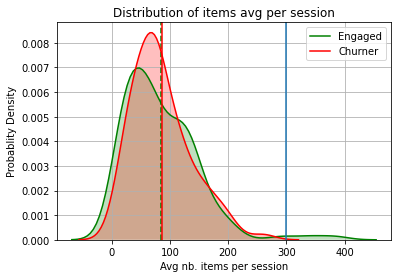

In [47]:
item_df = events_df.groupBy(["churn", "userId"])\
    .avg("itemInSession")\
    .withColumnRenamed("avg(itemInSession)", "avg_itemInSession") \
    .toPandas()
utils.plot_distributions(
    item_df, "churn", "Distribution of items avg per session",
    "avg_itemInSession", xlabel="Avg nb. items per session")
plt.axvline(300);

It appears that the average number of items per session doesn't seem to help on average to distinguish between the churning and engaged users. Around 100 sessions, the engaged users average number of items per session tends to be higher than for the churners. We can also see a clear separation between the churned and engaged users starting from `300` items per session.

### Average number of sessions per user

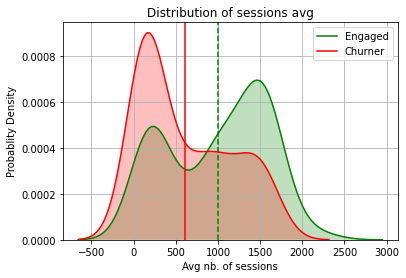

In [48]:
item_df = events_df.groupBy(["churn", "userId"])\
    .avg("sessionId")\
    .withColumnRenamed("avg(sessionId)", "avg_sessionId") \
    .toPandas()
utils.plot_distributions(
    item_df, "churn",
    "Distribution of sessions avg", "avg_sessionId",
    xlabel="Avg nb. of sessions")

The number of sessions per user tends n average to distinguish between the churned and engaged users. The churners tend to have a lower average number of sessions per day than the engaged users. If leaveraged as a feature it might be automatically picked-up by a tree based model e.g decision tree

### User Thumbs Up events number distribution

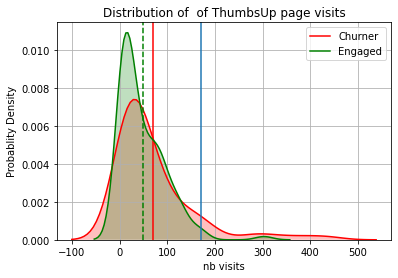

In [49]:
item_df = events_df.filter(events_df.page=="Thumbs Up")\
    .groupBy(["userId", "churn"]).count().toPandas()
utils.plot_distributions(item_df, "churn",
                         "Distribution of  of ThumbsUp page visits",
                         "count",
                        xlabel="nb visits")
plt.axvline(170);

Having a value greater than 200 thumbsUp page visits (combined with other features) might be an indicator for high risk of churn. This is kind of counter intuitive but at the same time this tells us that user that is engaged the most might be the one who penalizes the service the most easily.

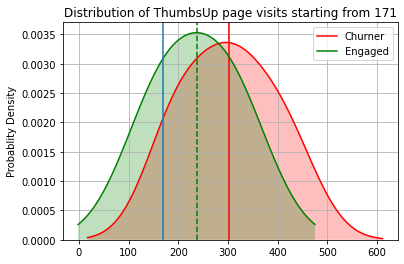

In [50]:
item_df = events_df.filter(events_df.page=="Thumbs Up")\
    .groupBy(["userId", "churn"]).count().toPandas()
item_df = item_df[item_df["count"] > 170]

utils.plot_distributions(item_df, "churn",
                         "Distribution of ThumbsUp page visits starting from 171", "count")
plt.axvline(170);

### User Thumbs Down events number distribution

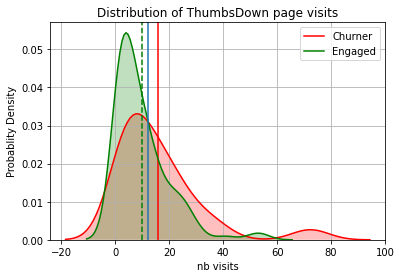

In [51]:
item_df = events_df.filter(events_df.page=="Thumbs Down").groupBy(["userId", "churn"]).count().toPandas()
utils.plot_distributions(item_df, "churn",
                         "Distribution of ThumbsDown page visits", "count",
                        xlabel="nb visits")
plt.axvline(12);

In general, it appears that churning users have less interactions in regard of giving a Thumbs up or down to a song.

But, we observe that pages distribution is chifted towards a `higher` number of `thumbsDown page visits` for churning users.
Using the number of thumbs down pages visit as a feature might help the model to separate the churning users from the engaged ones.

## Pages visits distribution:
### Error, NextSong, Home, RollAdvert

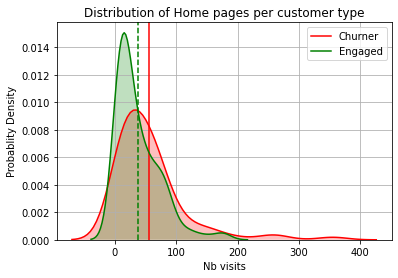

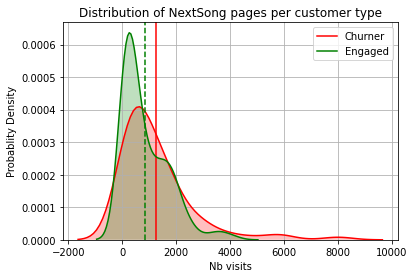

In [52]:
for index, page_name in enumerate(["Home", "NextSong"]):
    item_df = events_df.filter(events_df.page == page_name) \
                .groupBy(["userId", "churn"]).count().toPandas()
    plt.figure(index)
    utils.plot_distributions(item_df, "churn",
                             "Distribution of {} pages per customer type" \
                             .format(page_name), "count",
                            xlabel="Nb visits")
    plt.show()

In [53]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

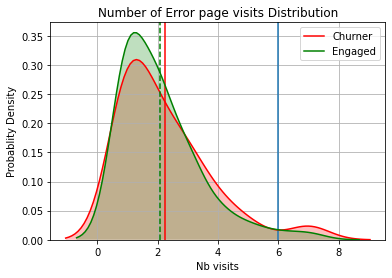

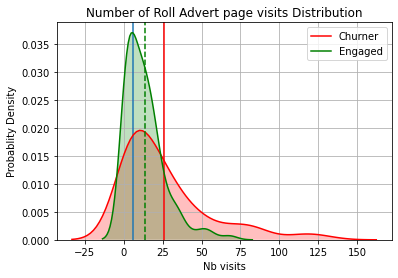

In [54]:
for index, page_name in enumerate(["Error", "Roll Advert"]):
    item_df = events_df.filter(events_df.page == page_name) \
                .groupBy(["userId", "churn"]).count().toPandas()
    plt.figure(index)
    plt.axvline(6)
    utils.plot_distributions(item_df, "churn",
                             "Number of {} page visits Distribution" \
                             .format(page_name), "count",
                            xlabel="Nb visits")
    plt.show()


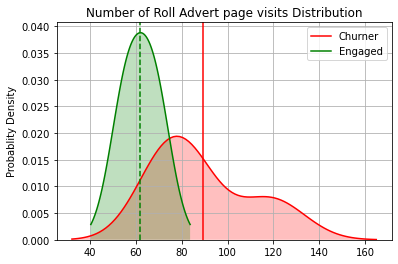

In [55]:
page_name = "Roll Advert"
item_df = events_df.filter(events_df.page == page_name) \
            .groupBy(["userId", "churn"]).count().toPandas()
item_df = item_df[item_df["count"] > 55]
plt.figure(index)
utils.plot_distributions(item_df, "churn",
                         "Number of {} page visits Distribution" \
                         .format(page_name), "count")
plt.show()

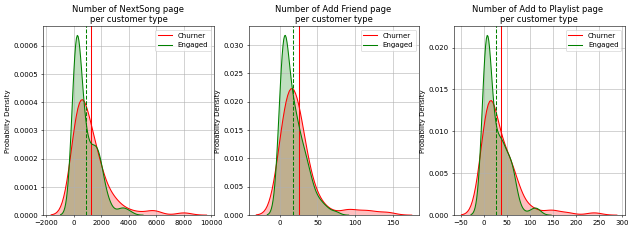

In [56]:
my_dpi = 40
fig = plt.figure(figsize=(15, 5), dpi=50)
for index, page_name in enumerate(["NextSong", "Add Friend", "Add to Playlist"]):
    ax3 = fig.add_subplot(1, 3, index + 1)
    item_df = events_df.filter(events_df.page == page_name) \
                .groupBy(["userId", "churn"]).count().toPandas()
    utils.plot_distributions(item_df, "churn",
                             "Number of {} page \nper customer type" \
                             .format(page_name), "count")
plt.show()